<a href="https://colab.research.google.com/github/tfrizza/DALL-E-tf/blob/main/CIFAR10_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tfrizza/DALL-E-tf.git

Cloning into 'DALL-E-tf'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 31 (delta 13), reused 20 (delta 9), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [1]:
%cd DALL-E-tf

/content/DALL-E-tf


In [39]:
import tensorflow as tf
from tensorflow.keras import Model, mixed_precision
from tensorflow.keras.losses import Loss, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl

from dall_e_tf.encoder import dvae_encoder
from dall_e_tf.decoder import dvae_decoder
from dall_e_tf.utils import plot_reconstructions

mixed_precision.set_global_policy('mixed_float16')

(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [75]:
vocab_size = 512
n_hid = 128

enc = dvae_encoder(img_size=32, group_count=2, n_hid=n_hid, n_blk_per_group=2, input_channels=x_train.shape[-1], vocab_size=vocab_size)
dec = dvae_decoder(group_count=2, n_init=n_hid//2, n_hid=n_hid, n_blk_per_group=2, output_channels=x_train.shape[-1], vocab_size=vocab_size)

def dVAE(enc, dec, temperature=1/16):
    z_e = enc.output # encoder logits

    z_q = tfpl.DistributionLambda(
        lambda logits: tfd.RelaxedOneHotCategorical(temperature, logits) # Gumbel-softmax
    )(z_e)

    z_hard = tf.math.argmax(z_e, axis=-1) # non-differentiable
    z_hard = tf.one_hot(z_hard, enc.output.shape[-1], dtype=tf.float16)

    z = z_q + tf.stop_gradient(z_hard - z_q) # straight-through Gumbel-softmax
    x_rec = dec(z)
    latents = tf.stack([z_hard, z_q],-1, name='latent')
    return Model(enc.input, [x_rec, latents])

vae = dVAE(enc, dec, 0.1)
vae.summary(line_length=200)

Model: "model_62"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_41 (InputLayer)                                             [(None, 32, 32, 3)]                         0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
conv2d_798 (Conv2D)                                               (None, 32, 32, 128)                         18944                   input_41[0][0]                              

In [76]:
BETA = 1.0

class LatentLoss(Loss):
  def call(self, dummy_ground_truth, outputs):
    global BETA
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    return vq_loss + BETA * commit_loss

In [77]:
vae.compile(loss=['mse', LatentLoss()], loss_weights=[1, 0.1], optimizer=Adam(1e-3))

vae.fit(x_train, x_train,
        validation_data=(x_test, x_test),
        epochs=100,
        batch_size=32,
        shuffle=True)

Epoch 1/100
1563/1563 [==============================] - 36s 21ms/step - loss: 0.0253 - model_61_loss: 0.0249 - tf.stack_20_loss: 0.0045 - val_loss: 0.0066 - val_model_61_loss: 0.0062 - val_tf.stack_20_loss: 0.0040
Epoch 2/100
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0064 - model_61_loss: 0.0060 - tf.stack_20_loss: 0.0039 - val_loss: 0.0062 - val_model_61_loss: 0.0058 - val_tf.stack_20_loss: 0.0037
Epoch 3/100
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0057 - model_61_loss: 0.0053 - tf.stack_20_loss: 0.0038 - val_loss: 0.0058 - val_model_61_loss: 0.0054 - val_tf.stack_20_loss: 0.0038
Epoch 4/100
1563/1563 [==============================] - 32s 20ms/step - loss: 0.0058 - model_61_loss: 0.0054 - tf.stack_20_loss: 0.0037 - val_loss: 0.0056 - val_model_61_loss: 0.0052 - val_tf.stack_20_loss: 0.0038
Epoch 5/100
1563/1563 [==============================] - 32s 20ms/step - loss: 0.0059 - model_61_loss: 0.0055 - tf.stack_20_loss: 0.0038 - v

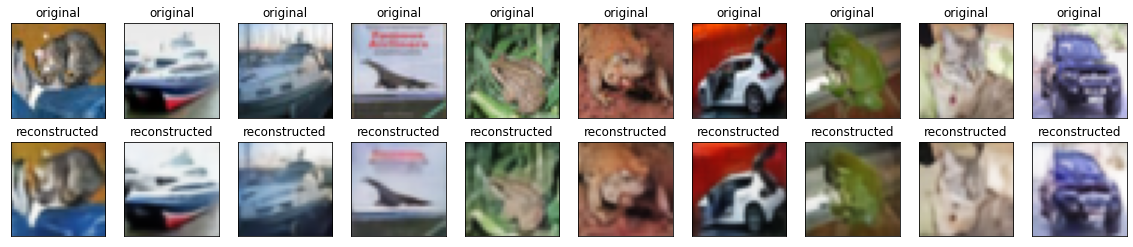

In [78]:
plot_reconstructions(vae(x_test[:10])[0], x_test[:10])